In [321]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

import utils

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

In [322]:
! ls ../Feb16_2017

DYJetsToLL_Pt-100To250                  TTToHadronic
DYJetsToLL_Pt-250To400                  TTToSemiLeptonic
DYJetsToLL_Pt-400To650                  VBFHToTauTau
DYJetsToLL_Pt-50To100                   VBFHToWWToLNuQQ_M-125_withDipoleRecoil
DYJetsToLL_Pt-650ToInf                  WJetsToLNu_HT-100To200
GluGluHToTauTau                         WJetsToLNu_HT-1200To2500
GluGluHToWWToLNuQQ                      WJetsToLNu_HT-200To400
GluGluHToWW_Pt-200ToInf_M-125           WJetsToLNu_HT-2500ToInf
HWminusJ_HToWW_M-125                    WJetsToLNu_HT-400To600
HWplusJ_HToWW_M-125                     WJetsToLNu_HT-600To800
HZJ_HToWW_M-125                         WJetsToLNu_HT-70To100
QCD_Pt_1000to1400                       WJetsToLNu_HT-800To1200
QCD_Pt_1400to1800                       WJetsToQQ_HT-200to400
QCD_Pt_170to300                         WJetsToQQ_HT-400to600
QCD_Pt_1800to2400                       WJetsToQQ_HT-600to800
QCD_Pt_2400to3200                       WJetsToQQ_HT-800toInf
QCD

# Read parquets
- loads parquet dataframes and combine different pt-bins per sample
- applies a specified preselection
- saves the combined dataframe under `events[ch][sample]`

In [384]:
year = "2017"
channels = ["mu", "ele"]

samples_dir = "../Feb16_2017"
samples = os.listdir(samples_dir)

combine_samples = {
    # data
    "SingleElectron_": "SingleElectron",    
    "SingleMuon_": "SingleMuon",  
    "EGamma_": "EGamma",    
    
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",    
    "HToWW_M-125": "VH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    
    # bkg
    "QCD_Pt": "QCD",
    "DYJets": "DYJets",    
    "WJetsToLNu_": "WJetsLNu",
    "JetsToQQ": "WZQQ",
    "TT": "TTbar",
    "ST_": "SingleTop",
    "WW": "Diboson",
    "WZ": "Diboson",
    "ZZ": "Diboson",
}

weights = {
    "mu": {
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_isolation_muon": 1,
        "weight_id_muon": 1,
        "weight_vjets_nominal": 1,
    },
    "ele":{
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_electron": 1,
        "weight_reco_electron": 1,
        "weight_id_electron": 1,
        "weight_vjets_nominal": 1,   
    }
}

In [385]:
events_dict = {}

for ch in channels:
    print("-------------------------------------------")
    print(f"{ch} channel")
    events_dict[ch] = {}
    # get lumi
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch][year]

    for sample in samples:

        ### get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample

        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                

        data = pd.read_parquet(parquet_files)
        not_empty = len(data) > 0

        # get event_weight
        print("---> Accumulating event weights.")                
        event_weight = utils.get_xsecweight(pkl_files, year, sample, False, luminosity)
        for w in weights[ch]:
            if w not in data.keys():
                print(f"{w} weight is not stored in parquet")
                continue
            event_weight *= data[w]
        data["event_weight"] = event_weight
        print("---> Done with accumulating event weights.")                       

        print(f"Will fill the {sample_to_use} dataframe with the remaining {len(data)} events")
        print(f"tot event weight {data['event_weight'].sum()} \n")

        # fill the big dataframe
        if sample_to_use not in events_dict[ch].keys():
            events_dict[ch][sample_to_use] = data
        else:
            events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data])

-------------------------------------------
mu channel
Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 964 events
tot event weight 1567.6018080746474 

Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the DYJets dataframe with the remaining 9908 events
tot event weight 100.02825996279239 

Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the VBF dataframe with the remaining 1177 events
tot event weight 58.02846654329544 

Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
---> Accumulating event weights.
weight_vjets_nominal 

---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the TTbar dataframe with the remaining 42758 events
tot event weight 5140.493743924925 

Finding QCD_Pt_1000to1400 samples and should combine them under QCD
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 19732 events
tot event weight 299.9065435179361 

Finding QCD_Pt_600to800 samples and should combine them under QCD
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 14340 events
tot event weight 4603.843468895331 

Finding QCD_Pt_300to470 samples and should combine them under QCD
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event 

---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 263660 events
tot event weight 3362.440912992296 

Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 95757 events
tot event weight 41943.206715464206 

Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the SingleTop dataframe with the remaining 9802 events
tot event weight 2078.2823638027185 

Finding WplusHToTauTau samples and should combine them under WplusHToTauTau
No parquet file for WplusHToTauTau
Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Accumulating event weights.
weight_vjets_nominal we

Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WZQQ dataframe with the remaining 7609 events
tot event weight 1575.5459701917036 

Finding GluGluHToWWToLNuQQ samples and should combine them under Diboson
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the Diboson dataframe with the remaining 13812 events
tot event weight 202.8043775478984 

Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 77538 events
tot event weight 92.25364179961504 

Finding ttHToNonbb_M125 samples and should combine them under ttHToNonbb_M125
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating e

In [386]:
events_dict.keys()

dict_keys(['mu', 'ele'])

In [387]:
events_dict['mu'].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttHToNonbb_M125'])

# Tagger outputs

In [390]:
### output of ParT_all_nodes tagger (includes a mass regression node)
for key in events_dict[ch]["TTbar"].keys():
    if "ParT" in key:
        print(key)

fj_ParT_all_nodes_probHWqqWqq0c
fj_ParT_all_nodes_probHWqqWqq1c
fj_ParT_all_nodes_probHWqqWqq2c
fj_ParT_all_nodes_probHWqqWq0c
fj_ParT_all_nodes_probHWqqWq1c
fj_ParT_all_nodes_probHWqqWq2c
fj_ParT_all_nodes_probHWqqWev0c
fj_ParT_all_nodes_probHWqqWev1c
fj_ParT_all_nodes_probHWqqWmv0c
fj_ParT_all_nodes_probHWqqWmv1c
fj_ParT_all_nodes_probHWqqWtauev0c
fj_ParT_all_nodes_probHWqqWtauev1c
fj_ParT_all_nodes_probHWqqWtaumv0c
fj_ParT_all_nodes_probHWqqWtaumv1c
fj_ParT_all_nodes_probHWqqWtauhv0c
fj_ParT_all_nodes_probHWqqWtauhv1c
fj_ParT_all_nodes_probHbb
fj_ParT_all_nodes_probHcc
fj_ParT_all_nodes_probHss
fj_ParT_all_nodes_probHqq
fj_ParT_all_nodes_probHtauhtaue
fj_ParT_all_nodes_probHtauhtaum
fj_ParT_all_nodes_probHtauhtauh
fj_ParT_all_nodes_probQCDbb
fj_ParT_all_nodes_probQCDcc
fj_ParT_all_nodes_probQCDb
fj_ParT_all_nodes_probQCDc
fj_ParT_all_nodes_probQCDothers
fj_ParT_all_nodes_probTopbWqq0c
fj_ParT_all_nodes_probTopbWqq1c
fj_ParT_all_nodes_probTopbWq0c
fj_ParT_all_nodes_probTopbWq1c
fj_Pa

In [391]:
### output of PN_v2 tagger (includes a mass regression node)
for key in events_dict[ch]["TTbar"].keys():
    if "PN_v2" in key:
        print(key)

fj_PN_v2_probHWqqWqq0c
fj_PN_v2_probHWqqWqq1c
fj_PN_v2_probHWqqWqq2c
fj_PN_v2_probHWqqWq0c
fj_PN_v2_probHWqqWq1c
fj_PN_v2_probHWqqWq2c
fj_PN_v2_probHWqqWev0c
fj_PN_v2_probHWqqWev1c
fj_PN_v2_probHWqqWmv0c
fj_PN_v2_probHWqqWmv1c
fj_PN_v2_probHWqqWtauev0c
fj_PN_v2_probHWqqWtauev1c
fj_PN_v2_probHWqqWtaumv0c
fj_PN_v2_probHWqqWtaumv1c
fj_PN_v2_probHWqqWtauhv0c
fj_PN_v2_probHWqqWtauhv1c
fj_PN_v2_probHbb
fj_PN_v2_probHcc
fj_PN_v2_probHss
fj_PN_v2_probHqq
fj_PN_v2_probHtauhtaue
fj_PN_v2_probHtauhtaum
fj_PN_v2_probHtauhtauh
fj_PN_v2_probQCDbb
fj_PN_v2_probQCDcc
fj_PN_v2_probQCDb
fj_PN_v2_probQCDc
fj_PN_v2_probQCDothers
fj_PN_v2_probTopbWqq0c
fj_PN_v2_probTopbWqq1c
fj_PN_v2_probTopbWq0c
fj_PN_v2_probTopbWq1c
fj_PN_v2_probTopbWev
fj_PN_v2_probTopbWmv
fj_PN_v2_probTopbWtauhv
fj_PN_v2_probTopbWtauev
fj_PN_v2_probTopbWtaumv
fj_PN_v2_mass
fj_PN_v2_probQCD
fj_PN_v2_probTopb
fj_PN_v2_probHWWelenuqq
fj_PN_v2_probHWWmunuqq


# Mass regression

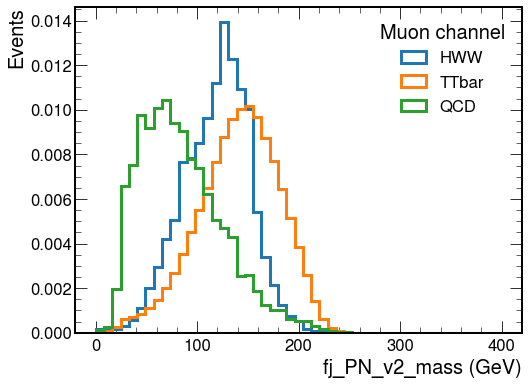

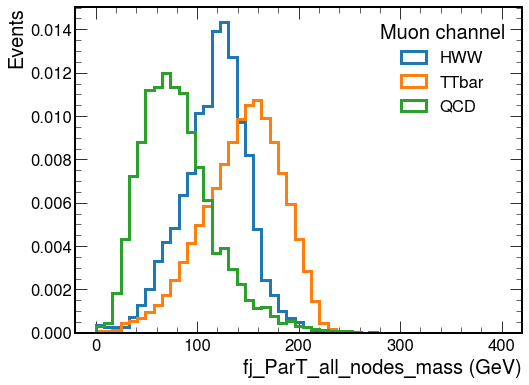

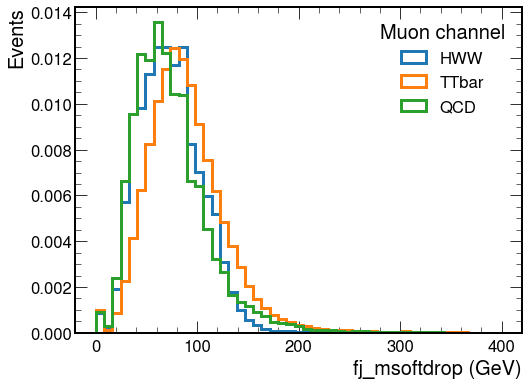

In [392]:
plt.rcParams.update({"font.size": 20})
samples_to_plot = ["HWW", "TTbar", "QCD"]

ch = "mu"

### regressed mass PN_v2
fig, ax = plt.subplots(figsize=(8, 6))
bins_ = np.linspace(0,400)
mass_ = "fj_PN_v2_mass"
for sample in samples_to_plot:
    ax.hist(
        events_dict[ch][sample][mass_].values,
        bins_,
        label=sample,
        linewidth=3,
        density=True,
        histtype="step",
        weights=events_dict[ch][sample]["event_weight"].values
    )    
ax.legend(title=f"{xch} channel")
ax.set_ylabel("Events")
ax.set_xlabel(f"{mass_} (GeV)");

### softdrop mass ParT
fig, ax = plt.subplots(figsize=(8, 6))
bins_ = np.linspace(0,400)
mass_ = "fj_ParT_all_nodes_mass"
for sample in samples_to_plot:
    ax.hist(
        events_dict[ch][sample][mass_].values,
        bins_,
        label=sample,
        linewidth=3,
        density=True,
        histtype="step",
        weights=events_dict[ch][sample]["event_weight"].values
    )    
ax.legend(title=f"{xch} channel")
ax.set_ylabel("Events")
ax.set_xlabel(f"{mass_} (GeV)");

### softdrop mass
fig, ax = plt.subplots(figsize=(8, 6))
bins_ = np.linspace(0,400)
mass_ = "fj_msoftdrop"
for sample in samples_to_plot:
    ax.hist(
        events_dict[ch][sample][mass_].values,
        bins_,
        label=sample,
        linewidth=3,
        density=True,
        histtype="step",
        weights=events_dict[ch][sample]["event_weight"].values
    )    
ax.legend(title=f"{xch} channel")
ax.set_ylabel("Events")
ax.set_xlabel(f"{mass_} (GeV)");

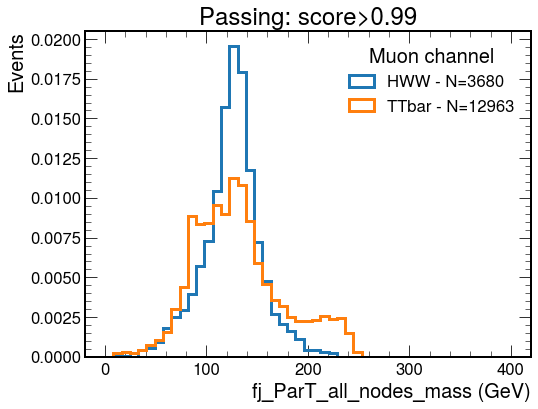

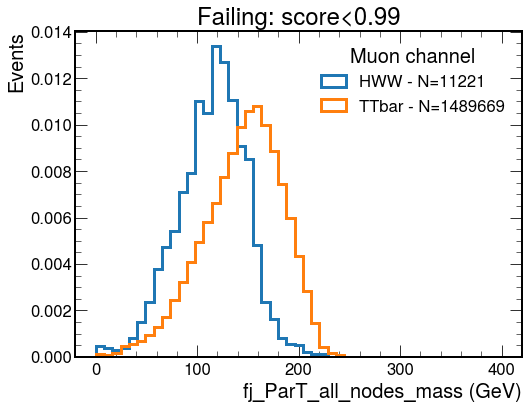

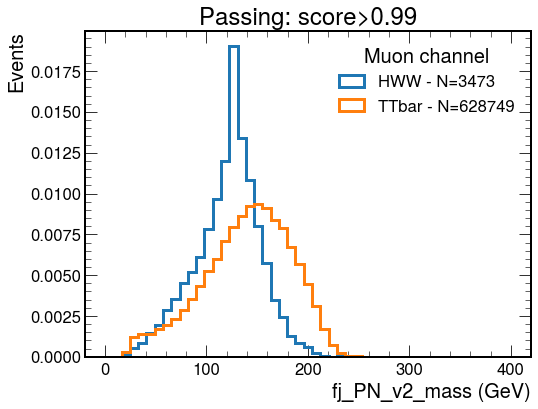

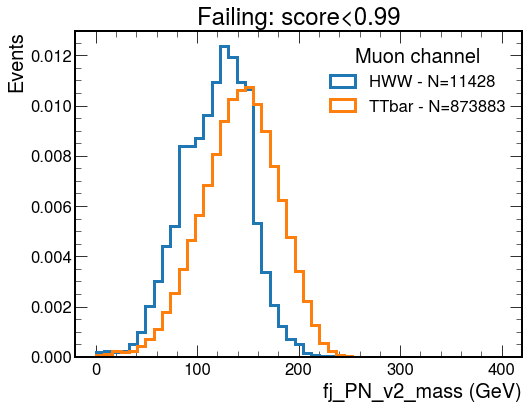

In [393]:
plt.rcParams.update({"font.size": 20})

ch = "mu"

sigs = ["fj_pnversion_probHWqqWmv0c",
         "fj_pnversion_probHWqqWmv1c",
         "fj_pnversion_probHWqqWtauev0c",
         "fj_pnversion_probHWqqWtaumv1c"]

qcds = ["fj_pnversion_probQCDbb",
        "fj_pnversion_probQCDcc",
        "fj_pnversion_probQCDb",
        "fj_pnversion_probQCDc",
        "fj_pnversion_probQCDothers"]

tops = ["fj_pnversion_probTopbWmv",
        "fj_pnversion_probTopbWtaumv"]


### regressed mass
bins_ = np.linspace(0,400)

PNs = ["ParT_all_nodes","PN_v2"]

for pn_version in PNs:
    new_sigs = [s.replace("pnversion",pn_version) for s in sigs]
    new_qcds = [s.replace("pnversion",pn_version) for s in qcds]    
    new_tops = [s.replace("pnversion",pn_version) for s in tops]

    ### make plots
    fig, ax1 = plt.subplots(figsize=(8, 6))
    fig, ax2 = plt.subplots(figsize=(8, 6))
    
    # samples_to_plot = ["HWW", "QCD"]
    samples_to_plot = ["HWW", "TTbar"]

    for sample in samples_to_plot:

        higgs_score = events_dict[ch][sample][new_sigs].sum(axis=1)
    #     bkg_score = events_dict[ch][sample][new_qcds].sum(axis=1) 
        bkg_score = events_dict[ch][sample][new_tops].sum(axis=1) 

        disc = higgs_score / (higgs_score+bkg_score)

        cut = 0.99

        mass_ = f"fj_{pn_version}_mass"
    #     mass_ = "fj_msoftdrop"

        ### passing region
        disc_ = disc>cut
        ax1.hist(
            events_dict[ch][sample][mass_][disc_].values,
            bins_,
            label=f"{sample} - N={len(events_dict[ch][sample][mass_][disc_].values)}",
            linewidth=3,
            density=True,
            histtype="step",
            weights=events_dict[ch][sample]["event_weight"][disc_].values
        )    
        ax1.legend(title=f"{xch} channel")
        ax1.set_ylabel("Events")
        ax1.set_xlabel(f"{mass_} (GeV)")
        ax1.set_title(f"Passing: score>{cut}");

        ### failing region
        disc_ = disc<cut
        ax2.hist(
            events_dict[ch][sample][mass_][disc_].values,
            bins_,
            label=f"{sample} - N={len(events_dict[ch][sample][mass_][disc_].values)}",
            linewidth=3,
            density=True,
            histtype="step",
            weights=events_dict[ch][sample]["event_weight"][disc_].values
        )      
        ax2.legend(title=f"{xch} channel")
        ax2.set_ylabel("Events")
        ax2.set_xlabel(f"{mass_} (GeV)")
        ax2.set_title(f"Failing: score<{cut}");

# Comparing all networks

In [394]:
def med_iqr(arr):
    if len(arr) > 0:
        p25 = np.percentile(arr, 25)
        p50 = np.percentile(arr, 50)
        p75 = np.percentile(arr, 75)
    else:
        p25 = 0.0
        p50 = 0.0
        p75 = 0.0
    return p50, p75 - p25

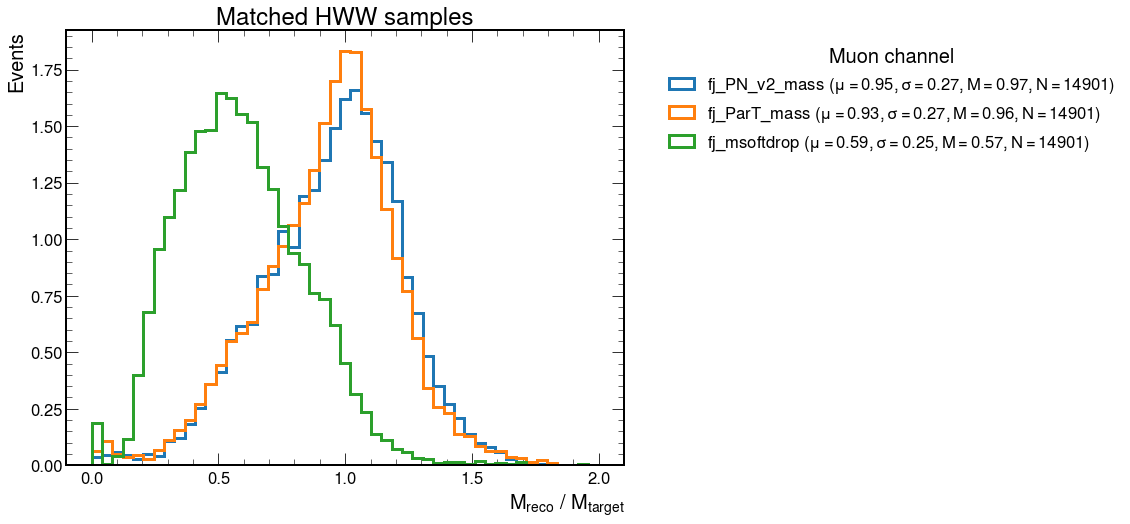

In [395]:
plt.rcParams.update({"font.size": 20})

ch = "mu"

### make plots
fig, ax = plt.subplots(figsize=(10, 8))
bins_ = np.linspace(0,2)

match_bool = events_dict[ch]["HWW"]["fj_H_VV_isMatched"].values

X = events_dict[ch]["HWW"]["fj_PN_v2_mass"][match_bool].values/125
p = med_iqr(X)
n_matched = len(X)
ax.hist(
    X,
    bins_,
    label="fj_PN_v2_mass $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(np.mean(X), np.std(X), p[0], n_matched),        
    linewidth=3,
    density=True,
    histtype="step"
)  
X = events_dict[ch]["HWW"]["fj_ParT_all_nodes_mass"][match_bool].values/125
p = med_iqr(X)
n_matched = len(X)
ax.hist(
    X,
    bins_,
    label="fj_ParT_mass $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(np.mean(X), np.std(X), p[0], n_matched),        
    linewidth=3,
    density=True,
    histtype="step"
)   
X = events_dict[ch]["HWW"]["fj_msoftdrop"][match_bool].values/125
p = med_iqr(X)
n_matched = len(X)
ax.hist(
    X,
    bins_,
    label="fj_msoftdrop $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(np.mean(X), np.std(X), p[0], n_matched),    
    linewidth=3,
    density=True,
    histtype="step"
)  
ax.legend(title=f"{xch} channel", bbox_to_anchor=(1.05, 1), loc="upper left",)
ax.set_ylabel("Events")
ax.set_xlabel("$M_{reco}$ / $M_{target}$")
ax.set_xticks([0,0.5,1,1.5,2])
ax.set_title(f"Matched HWW samples");

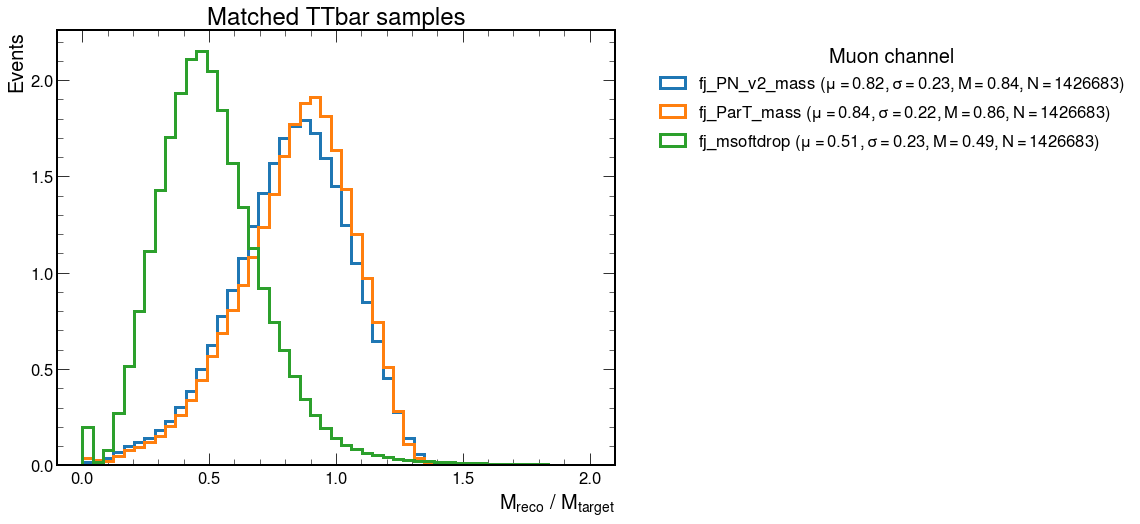

In [396]:
plt.rcParams.update({"font.size": 20})

ch = "mu"

### make plots
fig, ax = plt.subplots(figsize=(10, 8))
bins_ = np.linspace(0,2)

match_bool = events_dict[ch]["TTbar"]["fj_Top_isMatched"].values

X = events_dict[ch]["TTbar"]["fj_PN_v2_mass"][match_bool].values/173
p = med_iqr(X)
n_matched = len(X)
ax.hist(
    X,
    bins_,
    label="fj_PN_v2_mass $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(np.mean(X), np.std(X), p[0], n_matched),        
    linewidth=3,
    density=True,
    histtype="step"
)  
X = events_dict[ch]["TTbar"]["fj_ParT_all_nodes_mass"][match_bool].values/173
p = med_iqr(X)
n_matched = len(X)
ax.hist(
    X,
    bins_,
    label="fj_ParT_mass $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(np.mean(X), np.std(X), p[0], n_matched),        
    linewidth=3,
    density=True,
    histtype="step"
)   
X = events_dict[ch]["TTbar"]["fj_msoftdrop"][match_bool].values/173
p = med_iqr(X)
n_matched = len(X)
ax.hist(
    X,
    bins_,
    label="fj_msoftdrop $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(np.mean(X), np.std(X), p[0], n_matched),    
    linewidth=3,
    density=True,
    histtype="step"
)  
ax.legend(title=f"{xch} channel", bbox_to_anchor=(1.05, 1), loc="upper left",)
ax.set_ylabel("Events")
ax.set_xlabel("$M_{reco}$ / $M_{target}$")
ax.set_xticks([0,0.5,1,1.5,2])
ax.set_title(f"Matched TTbar samples");

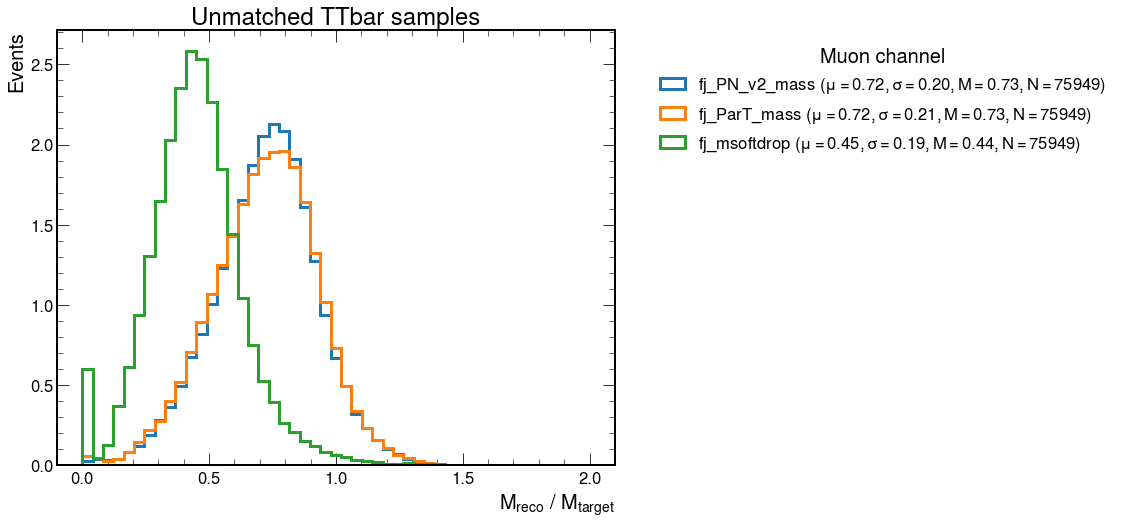

In [397]:
plt.rcParams.update({"font.size": 20})

ch = "mu"

### make plots
fig, ax = plt.subplots(figsize=(10, 8))
bins_ = np.linspace(0,2)

match_bool = (events_dict[ch]["TTbar"]["fj_Top_isMatched"].values) == False

X = events_dict[ch]["TTbar"]["fj_PN_v2_mass"][match_bool].values/173
p = med_iqr(X)
n_matched = len(X)
ax.hist(
    X,
    bins_,
    label="fj_PN_v2_mass $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(np.mean(X), np.std(X), p[0], n_matched),        
    linewidth=3,
    density=True,
    histtype="step"
)  
X = events_dict[ch]["TTbar"]["fj_ParT_all_nodes_mass"][match_bool].values/173
p = med_iqr(X)
n_matched = len(X)
ax.hist(
    X,
    bins_,
    label="fj_ParT_mass $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(np.mean(X), np.std(X), p[0], n_matched),        
    linewidth=3,
    density=True,
    histtype="step"
)   
X = events_dict[ch]["TTbar"]["fj_msoftdrop"][match_bool].values/173
p = med_iqr(X)
n_matched = len(X)
ax.hist(
    X,
    bins_,
    label="fj_msoftdrop $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(np.mean(X), np.std(X), p[0], n_matched),    
    linewidth=3,
    density=True,
    histtype="step"
)  
ax.legend(title=f"{xch} channel", bbox_to_anchor=(1.05, 1), loc="upper left",)
ax.set_ylabel("Events")
ax.set_xlabel("$M_{reco}$ / $M_{target}$")
ax.set_xticks([0,0.5,1,1.5,2])
ax.set_title(f"Unmatched TTbar samples");

## Stacked hists

In [77]:
# plot histograms
color_by_sample = {
    "HWW": "coral",
    "ttHToNonbb_M125": "tab:olive",
    "VH": "tab:brown",
    "VBF": "tab:gray",

    "DYJets": "tab:purple",
    "QCD": "tab:orange",
    "Diboson": "orchid",    
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "WZQQ": "salmon",
    "SingleTop": "tab:cyan",
    
    "WplusHToTauTau": "tab:cyan",
    "WminusHToTauTau": "tab:cyan",
    "ttHToTauTau": "tab:cyan",
    "GluGluHToTauTau": "tab:cyan",
    "ZHToTauTau": "tab:cyan",
    "VBFHToTauTau": "tab:cyan",
}

plot_labels = {
    "HWW": "ggH(WW)-Pt200",    
    "ttHToNonbb_M125": "ttH(WW)",
    "VH": "VH(WW)",
    "VBF": r"VBFH(WW) $(qq\ell\nu)$",
    
    "DYJets": r"Z$(\ell\ell)$+jets",    
    "QCD": "Multijet",
    "Diboson": "VV",
    "WJetsLNu": r"W$(\ell\nu)$+jets",
    "TTbar": r"$t\bar{t}$+jets",
    "WZQQ": r"W/Z$(qq)$",
    "SingleTop": r"Single Top",
    
    "WplusHToTauTau": "WplusHToTauTau",
    "WminusHToTauTau": "WminusHToTauTau",
    "ttHToTauTau": "ttHToTauTau",
    "GluGluHToTauTau": "GluGluHToTauTau",
    "ZHToTauTau": "ZHToTauTau",
    "VBFHToTauTau": "VBFHToTauTau"
}

label_by_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# this is actually no longer by channel since I don't have channels for VH, but leave the name for now, since 2018 is different than other years:w
data_by_ch = {
    "ele": "SingleElectron",
    "mu": "SingleMuon",
    "had": "JetHT",
    "DoubleMuon": "DoubleMuon",
    "MuonEG": "MuonEG",
    "DoubleEG": "DoubleEG",
}
data_by_ch_2018 = {
    "ele": "EGamma",  # i guess there was no single electron for this year, so cristina used eGamma instead of single electron?
    "mu": "SingleMuon",
    "had": "JetHT",
    "DoubleMuon": "DoubleMuon",
    "MuonEG": "MuonEG",
}

signal_by_ch = {
    "ele": [
        "HWW",        
        "ttHToNonbb_M125",
        "VH",
        "VBFH",
    ],
    "mu": [
        "HWW",        
        "ttHToNonbb_M125",
        "VH",
        "VBF"
    ],
}

In [78]:
def plot_hists(hists, vars_to_plot, add_data = True, logy = True, add_soverb = True, only_sig = False):
    # data label
    data_label = data_by_ch[ch]
    if year == "2018":
        data_label = data_by_ch_2018[ch]

    # luminosity
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch_][year_]
        luminosity = luminosity / 1000.0

    #     if year_ == "Run2":
    #         data_label = "Data"

    for var in vars_to_plot:
        if var not in hists.keys():
            print(f"{var} not stored in hists")
            continue

        print(f"Will plot {var} histogram")

        # get histograms
        h = hists[var]

        if (h.shape[0] == 0):  # skip empty histograms (such as lepton_pt for hadronic channel)
            print("Empty histogram ", var)
            continue

        # get samples existing in histogram
        samples = [h.axes[0].value(i) for i in range(len(h.axes[0].edges))]
        signal_labels = [label for label in samples if label in signal_by_ch[ch]]
        bkg_labels = [
            label
            for label in samples
            if (label and label != data_label and label not in signal_labels)
        ]

        # get total yield of backgrounds per label
        # (sort by yield in fixed fj_pt histogram after pre-sel)        
        order_dic = {}
        for bkg_label in bkg_labels:
            if "fj_pt" in hists.keys():
                order_dic[plot_labels[bkg_label]] = hists["fj_pt"][{"samples": bkg_label}].sum()
            else:
                order_dic[plot_labels[bkg_label]] = hists[var][{"samples": bkg_label}].sum()
            
        # data
        data = None
        if data_label in h.axes[0]:
            data = h[{"samples": data_label}]

        # signal
        signal = [h[{"samples": label}] for label in signal_labels]
        # scale signal for non-log plots
        if logy:
            mult_factor = 1
        else:
            mult_factor = 100
        signal_mult = [s * mult_factor for s in signal]

        # background
        bkg = [h[{"samples": label}] for label in bkg_labels]

        if add_data and data and len(bkg) > 0:
            if add_soverb and len(signal) > 0:
                fig, (ax, rax, sax) = plt.subplots(
                    nrows=3,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1, 1), "hspace": 0.07},
                    sharex=True,
                )
            else:
                fig, (ax, rax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                sax = None
        else:
            if add_soverb and len(signal) > 0:
                fig, (ax, sax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                rax = None
            else:
                fig, ax = plt.subplots(1, 1)
                rax = None
                sax = None

        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
        }

        # sum all of the background
        if len(bkg) > 0:
            tot = bkg[0].copy()
            for i, b in enumerate(bkg):
                if i > 0:
                    tot = tot + b

            tot_val = tot.values()
            tot_val_zero_mask = tot_val == 0
            tot_val[tot_val_zero_mask] = 1

            tot_err = np.sqrt(tot_val)
            tot_err[tot_val_zero_mask] = 0

            # print(f'Background yield: ',tot_val,np.sum(tot_val))

        if add_data and data:
            data_err_opts = {
                "linestyle": "none",
                "marker": ".",
                "markersize": 10.0,
                "elinewidth": 1,
            }
            hep.histplot(
                data,
                ax=ax,
                histtype="errorbar",
                color="k",
                capsize=4,
                yerr=True,
                label=data_label,
                **data_err_opts,
            )

            if len(bkg) > 0:
                from hist.intervals import ratio_uncertainty

                data_val = data.values()
                data_val[tot_val_zero_mask] = 1

                yerr = ratio_uncertainty(data_val, tot_val, "poisson")

                hep.histplot(
                    data_val / tot_val,
                    tot.axes[0].edges,
                    # yerr=np.sqrt(data_val) / tot_val,
                    yerr=yerr,
                    ax=rax,
                    histtype="errorbar",
                    color="k",
                    capsize=4,
                )

                rax.axhline(1, ls="--", color="k")
                rax.set_ylim(0.2, 1.8)
                # rax.set_ylim(0.7, 1.3)

        # plot the background
        if len(bkg) > 0 and not only_sig:
            hep.histplot(
                bkg,
                ax=ax,
                stack=True,
                sort="yield",
                edgecolor="black",
                linewidth=1,
                histtype="fill",
                label=[plot_labels[bkg_label] for bkg_label in bkg_labels],
                color=[color_by_sample[bkg_label] for bkg_label in bkg_labels],
            )
            ax.stairs(
                values=tot.values() + tot_err,
                baseline=tot.values() - tot_err,
                edges=tot.axes[0].edges,
                **errps,
                label="Stat. unc.",
            )

        # plot the signal (times 10)
        if len(signal) > 0:
            tot_signal = None
            for i, sig in enumerate(signal_mult):
                lab_sig_mult = f"{mult_factor} * {plot_labels[signal_labels[i]]}"
                if mult_factor == 1:
                    lab_sig_mult = f"{plot_labels[signal_labels[i]]}"
                hep.histplot(
                    sig,
                    ax=ax,
                    label=lab_sig_mult,
                    linewidth=3,
                    color=color_by_sample[signal_labels[i]],
                )

                if tot_signal == None:
                    tot_signal = signal[i].copy()
                else:
                    tot_signal = tot_signal + signal[i]

            # plot the total signal (w/o scaling)
            hep.histplot(
                tot_signal, ax=ax, label=f"ggF+VBF+VH+ttH", linewidth=3, color="tab:red"
            )
            # add MC stat errors
            ax.stairs(
                values=tot_signal.values() + np.sqrt(tot_signal.values()),
                baseline=tot_signal.values() - np.sqrt(tot_signal.values()),
                edges=sig.axes[0].edges,
                **errps,
            )

            if sax is not None:
                totsignal_val = tot_signal.values()
                # replace values where bkg is 0
                totsignal_val[tot_val == 0] = 0
                soverb_val = totsignal_val / np.sqrt(tot_val)
                hep.histplot(
                    soverb_val,
                    tot_signal.axes[0].edges,
                    label="Total Signal",
                    ax=sax,
                    linewidth=3,
                    color="tab:red",
                )

                # integrate soverb in a given range for lep_fj_m (which, intentionally, is the first variable we pass)
                if var == "lep_fj_m":
                    bin_array = tot_signal.axes[0].edges[
                        :-1
                    ]  # remove last element since bins have one extra element
                    range_max = 150
                    range_min = 0

                    condition = (bin_array >= range_min) & (bin_array <= range_max)

                    s = totsignal_val[
                        condition
                    ].sum()  # sum/integrate signal counts in the range
                    b = np.sqrt(
                        tot_val[condition].sum()
                    )  # sum/integrate bkg counts in the range and take sqrt

                    soverb_integrated = round((s / b).item(), 2)
                    sax.legend(title=f"S/sqrt(B) (in 0-150)={soverb_integrated}")

        ax.set_ylabel("Events")
        if sax is not None:
            ax.set_xlabel("")
            if rax is not None:
                rax.set_xlabel("")
                rax.set_ylabel("Data/MC", fontsize=20)
            sax.set_ylabel(r"S/$\sqrt{B}$", fontsize=20)
#             sax.set_xlabel(f"{utils.axis_dict[var].label}")
            sax.set_xlabel(f"{h.axes[-1].label}")   # assumes the variable to be plotted is at the last axis
            
        elif rax is not None:
            ax.set_xlabel("")
#             rax.set_xlabel(f"{utils.axis_dict[var].label}")
            rax.set_xlabel(f"{h.axes[-1].label}")    # assumes the variable to be plotted is at the last axis
            
            rax.set_ylabel("Data/MC", fontsize=20)

        # get handles and labels of legend
        handles, labels = ax.get_legend_handles_labels()

        # append legend labels in order to a list
        summ = []
        for label in labels[: len(bkg_labels)]:
            summ.append(order_dic[label])
        # get indices of labels arranged by yield
        order = []
        for i in range(len(summ)):
            order.append(np.argmax(np.array(summ)))
            summ[np.argmax(np.array(summ))] = -100

        # plot data first, then bkg, then signal
        hand = [handles[-1]] + [handles[i] for i in order] + handles[len(bkg) : -1]
        lab = [labels[-1]] + [labels[i] for i in order] + labels[len(bkg) : -1]

        ax.legend(
            [hand[idx] for idx in range(len(hand))],
            [lab[idx] for idx in range(len(lab))],
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            title=f"{label_by_ch[ch]} Channel",
        )

        if logy:
            ax.set_yscale("log")
            ax.set_ylim(10)

        hep.cms.lumitext(
            "%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20
        )
        hep.cms.text("Work in Progress", ax=ax, fontsize=15)

In [80]:
year_ = "2017"
ch_ = "mu"

### get samples_to_plot
samples_to_plot = ["HWW", "QCD", "TTbar"]

# fill histograms
hists = {}

hists["fj_PKU_ParT_mass"] = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    hist2.axis.Regular(45, 20, 400, name="var", label=r"fj_PKU_ParT_mass [GeV]", overflow=True),
)

hists["fj_pt"] = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
     hist2.axis.Regular(30, 200, 1000, name="var", label=r"Jet $p_T$ [GeV]", overflow=True),
)

for sample in samples_to_plot:
    hists["fj_pt"].fill(
        samples=sample,
        var=events_dict[ch_][sample]["fj_pt"],
        weight=events_dict[ch_][sample]["event_weight"]
    )
    hists["fj_PKU_ParT_mass"].fill(
        samples=sample,
        var=events_dict[ch_][sample]["fj_PKU_ParT_mass"],
        weight=events_dict[ch_][sample]["event_weight"]
    )
    
hists["fj_PKU_ParT_mass"][{"samples": "HWW"}]        

Hist(Regular(45, 20, 400, name='var', label='fj_PKU_ParT_mass [GeV]'), storage=Double()) # Sum: 120.56545992989831 (121.27150061369925 with flow)

Will plot fj_PKU_ParT_mass histogram


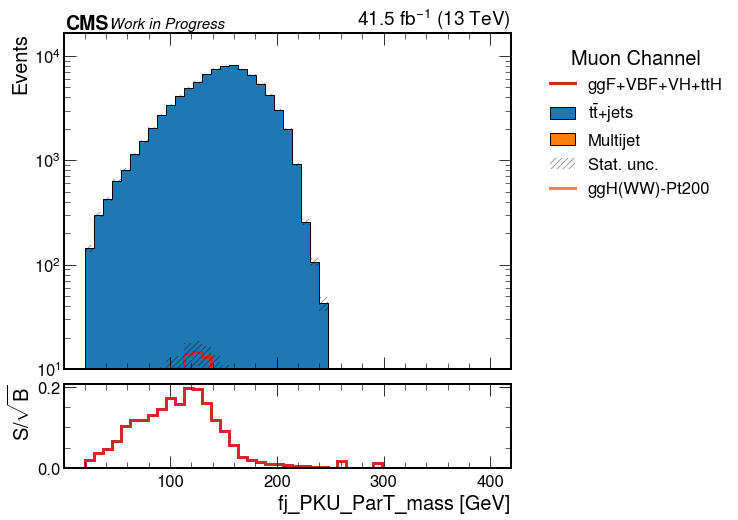

In [81]:
ch = "mu"
vars_to_plot = ["fj_PKU_ParT_mass"]

plot_hists(hists, vars_to_plot, add_data = True, logy = True, add_soverb = True, only_sig = False)